In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [17]:
import logging
import functools
import numpy as onp
import pandas as pd

import jax
import jax.numpy as np
import jax.scipy as sp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_sample
from numpyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
import numpyro.optim as optim
from numpyro.distributions.transforms import OrderedTransform
import numpyro.distributions.constraints as constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import palettes

sns.set_style("ticks", {"font.family": "serif", "font.serif": "Times New Roman"})
palettes.set_theme()
numpyro.set_host_device_count(4)

<IPython.core.display.Javascript object>

In [18]:
jax.local_device_count()

4

<IPython.core.display.Javascript object>

In [19]:
n_samples = 1000
K = 3

<IPython.core.display.Javascript object>

In [20]:
means = np.linspace(-2.0, 2.0, K)
means

DeviceArray([-2.,  0.,  2.], dtype=float32)

<IPython.core.display.Javascript object>

In [ ]:
Z = random.randint(
    key=random.PRNGKey(23), minval=0, maxval=K, shape=(n_samples,)
)

In [14]:
sds = np.array([0.25, 0.2, 0.3])

<IPython.core.display.Javascript object>

In [ ]:
eps = dist.Normal(0.0, 1.0).sample(
    random.PRNGKey(23), sample_shape=(n_samples,)
)
D = means[Z] + eps * sds[Z]

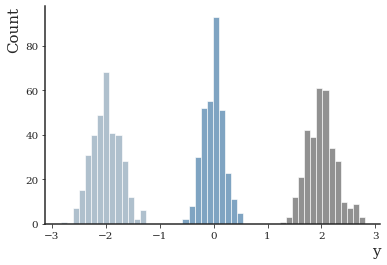

<IPython.core.display.Javascript object>

In [16]:
df = pd.DataFrame(np.vstack([D, Z]).T, columns=["y", "z"])
sns.histplot(
    x="y",
    hue="z",
    data=df,
    palette=palettes.discrete_sequential_colors(),
    legend=False,
    bins=50,
)
plt.show()

## A finite mixture

In [ ]:
def prior():
    pi = numpyro.sample(
        "pi",
        dist.Dirichlet(concentration=np.ones(K)),
    )

    mu = numpyro.sample(
        "mu",
        dist.TransformedDistribution(
            dist.Normal(loc=np.zeros(K)), OrderedTransform()
        ),
    )

    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=np.ones(K)))

    return pi, mu, sigma

In [ ]:
def log_likelihood(D, pi, mu, sigma):
    lpdf_weights = np.log(pi)
    lpdf_components = dist.Normal(loc=mu, scale=sigma).log_prob(
        D[:, np.newaxis]
    )

    lpdf = lpdf_weights + lpdf_components
    lpdf = sp.special.logsumexp(lpdf, axis=-1)
    return np.sum(lpdf)

In [ ]:
def model():
    pi, mu, sigma = prior()
    numpyro.factor("likelihood", log_likelihood(D, pi, mu, sigma))

In [ ]:
def guide():
    q_pi_concentration = numpyro.param(
        "pi_concentration",
        init_value=np.ones(K),
        constraint=constraints.positive,
    )
    q_pi = numpyro.sample(
        "pi",
        dist.Dirichlet(concentration=q_pi_concentration),
    )

    q_mu_mu = numpyro.param("q_mu_mu", init_value=np.array([-2.0, 0.0, 2.0]))
    q_mu_sd = numpyro.param(
        "q_mu_sd", init_value=np.ones(K), constraint=constraints.positive
    )
    q_mu = numpyro.sample(
        "mu",
        dist.TransformedDistribution(
            dist.Normal(loc=q_mu_mu, scale=q_mu_sd), OrderedTransform()
        ),
    )

    q_sigma_scale = numpyro.param(
        "q_sigma_scale", init_value=np.ones(K), constrain=constraints.positive
    )
    q_sigma = numpyro.sample(
        "sigma",
        dist.HalfNormal(scale=q_sigma_scale),
    )

In [15]:
adam = optim.Adam(0.001)
svi = SVI(model, guide, adam, loss=TraceGraph_ELBO(100))
res = svi.run(random.PRNGKey(23), num_steps=10000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.62it/s, init loss: 6027.7476, avg. loss [9501-10000]: 2248.0190]


In [ ]:
def plot_losses(res):
    fig, _ = plt.subplots(1, 1)
    ax = sns.lineplot(
        data=pd.DataFrame({"y": res.losses, "x": range(len(res.losses))}),
        y="y",
        x="x",
        color="black",
    )
    ax.set(xlabel="", ylabel="NLL")
    plt.show()

In [ ]:
def plot_means(res):
    var_posterior_mean = dist.TransformedDistribution(
        dist.Normal(loc=res.params["q_mu_mu"], scale=res.params["q_mu_sd"]),
        OrderedTransform(),
    )
    var_posterior_mean_samples = var_posterior_mean.sample(
        random.PRNGKey(0), sample_shape=(1000,)
    )
    K = var_posterior_mean_samples.shape[1]
    df = pd.DataFrame(
        var_posterior_mean_samples, columns=[f"mu{i}" for i in range(K)]
    )
    df = df.melt(var_name="Mu", value_name="Value")

    plt.figure(figsize=(10, 4))
    g = sns.FacetGrid(df, col="Mu", col_wrap=5, sharex=False, sharey=False)
    _ = g.map_dataframe(sns.histplot, x="Value", color="darkgrey")

    plt.show()

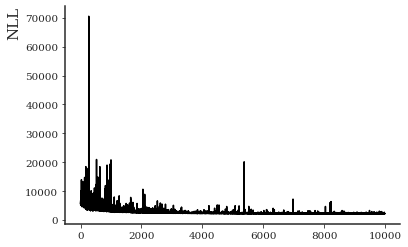

In [20]:
plot_losses(res)

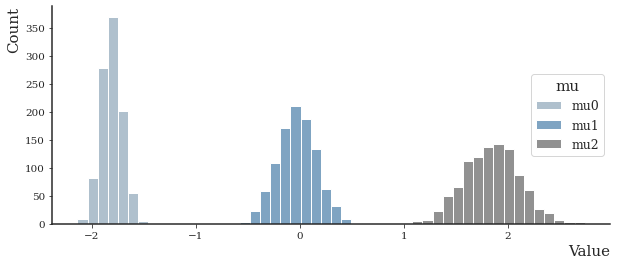

In [21]:
plot_means(res)

## An infinite mixture

In [201]:
K_stick = 10

In [ ]:
def sample_stick(nu):
    ones = np.ones((*nu.shape[:-1], 1))
    rem = np.concatenate([ones, np.cumprod(1 - nu, axis=-1)[:-1]], axis=-1)
    mix_probs = nu * rem
    return mix_probs

In [ ]:
def infinite_prior():
    beta = numpyro.sample("beta", dist.Gamma(1.0, 10.0))

    nu = numpyro.sample(
        "nu", dist.Beta(concentration1=np.ones(K_stick), concentration0=beta)
    )

    pi = numpyro.deterministic("pi", sample_stick(nu))

    mu = numpyro.sample(
        "mu",
        dist.TransformedDistribution(
            dist.Normal(loc=np.zeros(K_stick)), OrderedTransform()
        ),
    )

    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=np.ones(K_stick)))

    return pi, mu, sigma

In [205]:
with numpyro.handlers.seed(rng_seed=23):
    pi, mu, sigma = infinite_prior()

In [ ]:
def model():
    pi, mu, sigma = infinite_prior()
    numpyro.factor("likelihood", log_likelihood(D, pi, mu, sigma))

In [ ]:
def guide():
    q_beta_concentration = numpyro.param(
        "beta_concentration", init_value=1.0, constraint=constraints.positive
    )
    q_beta_rate = numpyro.param(
        "beta_rate", init_value=1.0, constraint=constraints.positive
    )
    q_beta = numpyro.sample(
        "beta", dist.Gamma(q_beta_concentration, q_beta_rate)
    )

    q_nu_concentration0 = numpyro.param(
        "nu_concentration0",
        init_value=np.ones(K_stick),
        constraint=constraints.positive,
    )
    q_nu = numpyro.sample(
        "nu",
        dist.Beta(concentration1=1.0, concentration0=q_nu_concentration0),
    )

    q_mu_mu = numpyro.param(
        "q_mu_mu", init_value=np.linspace(-2.0, 0.0, K_stick)
    )
    q_mu_sd = numpyro.param(
        "q_mu_sd", init_value=np.ones(K_stick), constraint=constraints.positive
    )
    q_mu = numpyro.sample(
        "mu",
        dist.TransformedDistribution(
            dist.Normal(loc=q_mu_mu, scale=q_mu_sd), OrderedTransform()
        ),
    )

    q_sigma_scale = numpyro.param(
        "q_sigma_scale",
        init_value=np.ones(K_stick),
        constrain=constraints.positive,
    )
    q_sigma = numpyro.sample("sigma", dist.HalfNormal(scale=q_sigma_scale))

In [208]:
adam = optim.Adam(0.001)
svi = SVI(model, guide, adam, loss=TraceGraph_ELBO(20))
res = svi.run(random.PRNGKey(23), num_steps=1000, )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.84it/s, init loss: 4376.7134, avg. loss [951-1000]: 2506.7280]


In [ ]:
nu = dist.Beta(
    concentration1=1.0, concentration0=res.params["nu_concentration0"]
)
sample_stick(nu.mean)

<Figure size 720x288 with 0 Axes>

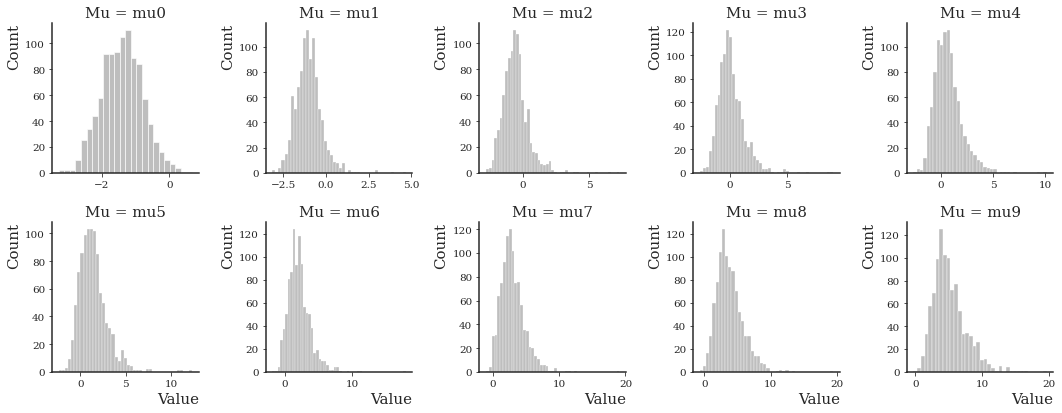

In [211]:
plot_means(res)

In [212]:
## Factor analysis

In [21]:
n_samples = 100
K = 10

<IPython.core.display.Javascript object>

In [22]:
nu = dist.Beta(2.0, 1.0).sample(random.PRNGKey(0), sample_shape=(K,))
pi = np.cumprod(nu)
pi

DeviceArray([0.926722  , 0.7400079 , 0.52786434, 0.33712   , 0.22903277,
             0.14449869, 0.12368181, 0.05622254, 0.04721373, 0.04337756],            dtype=float32)

<IPython.core.display.Javascript object>

In [23]:
pi

DeviceArray([0.926722  , 0.7400079 , 0.52786434, 0.33712   , 0.22903277,
             0.14449869, 0.12368181, 0.05622254, 0.04721373, 0.04337756],            dtype=float32)

<IPython.core.display.Javascript object>

In [24]:
Z = dist.Bernoulli(probs=pi).sample(random.PRNGKey(1), sample_shape=(n_samples,))

<IPython.core.display.Javascript object>

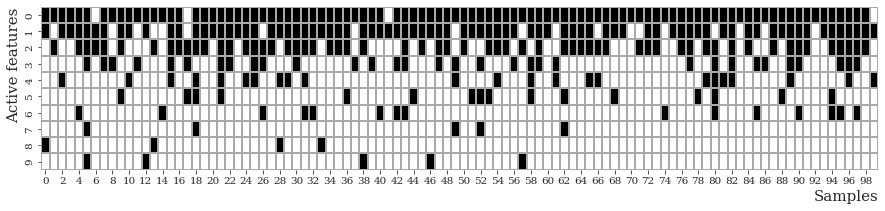

<IPython.core.display.Javascript object>

In [25]:
fig = plt.figure(figsize=(15, 3))
ax = sns.heatmap(
    Z.T,
    linewidths=0.1,
    cbar=False,
    cmap=["white", "black"],
    linecolor="darkgrey",
)
ax.set_ylabel("Active features")
ax.set_xlabel("Samples")
ax.minorticks_off()
plt.show()

In [26]:
Z = dist.Bernoulli(probs=pi).sample(random.PRNGKey(0), sample_shape=(n_samples,))
features = dist.Normal().sample(random.PRNGKey(0), sample_shape=(K,))

<IPython.core.display.Javascript object>

In [27]:
y = Z @ features

<IPython.core.display.Javascript object>

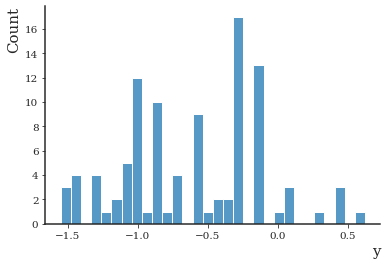

<IPython.core.display.Javascript object>

In [28]:
df = pd.DataFrame(y, columns=["y"])
sns.histplot(x="y", data=df, legend=False, bins=30)
plt.show()

In [29]:
import tensorflow_probability as tfp

<IPython.core.display.Javascript object>

In [30]:
import tensorflow_probability.substrates.jax.distributions as tfp_jax

<IPython.core.display.Javascript object>

In [31]:
def prior():
    nu = numpyro.sample("nu", dist.Beta(np.ones(K), 1.0))
    pi = numpyro.deterministic("pi", np.cumprod(nu))

    Z = numpyro.sample(
        "Z",
        tfp_jax.RelaxedBernoulli(0.00001, probs=pi),
        sample_shape=(n_samples,),
    )

    eta = numpyro.sample("eta", dist.Normal(np.zeros(K), 1.0))

    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))

    return nu, pi, Z, eta, sigma

<IPython.core.display.Javascript object>

In [32]:
def log_likelihood(y, pi, Z, eta, sigma):
    mean = Z @ eta
    lpdf = dist.Normal(loc=mean, scale=sigma).log_prob(y)
    return np.sum(lpdf)

<IPython.core.display.Javascript object>

In [33]:
def model():
    _, pi, Z, eta, sigma = prior()
    numpyro.factor("likelihood", log_likelihood(y, pi, Z, eta, sigma))

<IPython.core.display.Javascript object>

In [34]:
temperature = 0.000001
rec_temperature = np.reciprocal(temperature)

<IPython.core.display.Javascript object>

In [64]:
def guide():
    q_nu_concentration1 = numpyro.param(
        "nu_concentration1",
        init_value=np.ones(K),
        constraint=constraints.positive,
    )
    q_nu_concentration0 = numpyro.param(
        "nu_concentration0",
        init_value=np.ones(K) * 2.0,
        constraint=constraints.positive,
    )
    q_nu = numpyro.sample(
        "nu",
        dist.Beta(
            concentration1=q_nu_concentration1,
            concentration0=q_nu_concentration0,
        ),
    )

    z_logits = numpyro.param(
        "z_logits",
        init_value=np.tile(np.linspace(2.0, -2.0, K), (n_samples, 1)),
    )
    Z = numpyro.sample(
        "Z",
        dist.TransformedDistribution(
            dist.Logistic(z_logits * rec_temperature, rec_temperature),
            dist.transforms.SigmoidTransform(),
        ),
    )

    q_eta_mu = numpyro.param("eta_mu", init_value=np.zeros(K))
    eta = numpyro.sample("eta", dist.Normal(q_eta_mu, 1.0))

    q_sigma_scale = numpyro.param(
        "sigma_scale", init_value=1.0, constrain=constraints.positive
    )
    q_sigma = numpyro.sample("sigma", dist.HalfNormal(scale=q_sigma_scale))

<IPython.core.display.Javascript object>

In [65]:
from optax import chain, polynomial_schedule, rmsprop, scale_by_schedule, scale_by_rms

<IPython.core.display.Javascript object>

In [66]:
adam = optim.Adam(0.01)
svi = SVI(model, guide, adam, loss=TraceGraph_ELBO(20))
res = svi.run(random.PRNGKey(1), num_steps=25000)

100%|████| 25000/25000 [01:07<00:00, 370.37it/s, init loss: 1749005952.0000, avg. loss [23751-25000]: 1393071744.0000]


<IPython.core.display.Javascript object>

In [67]:
res.losses

DeviceArray([1.7490060e+09, 1.7637457e+09, 1.7394872e+09, ...,
             1.3927945e+09, 1.3803978e+09, 1.3874531e+09], dtype=float32)

<IPython.core.display.Javascript object>

In [68]:
features

DeviceArray([-0.372111  ,  0.2642311 , -0.18252774, -0.7368198 ,
             -0.44030386, -0.15214427, -0.6713536 , -0.59086424,
              0.73168874,  0.56730247], dtype=float32)

<IPython.core.display.Javascript object>

In [69]:
res.params["eta_mu"]

DeviceArray([ 0.51426077,  0.1553991 , -0.08521671,  0.03516082,
              0.36623764,  0.24850117, -0.14284499, -0.10754778,
              0.36995757,  0.37279823], dtype=float32)

<IPython.core.display.Javascript object>

In [51]:
1 / (1 + np.exp(5))

DeviceArray(0.00669285, dtype=float32)

<IPython.core.display.Javascript object>